In [1]:
# Python script to estimate the STARS foam model parameter from experimental data. 
# This is a python adoption of a Julia script written by A.A. Eftekhari, see https://github.com/simulkade/foamparameters. 
# The optimization solver does not handle the bound constraints very well. It needs to be improved.

In [2]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import CoolProp.CoolProp as CP
from scipy import stats, optimize
from sklearn import linear_model
mpl.use('TkAgg')
import matplotlib.pyplot as plt
######################################################################
# Plot configurations
# mpl.style.use('classic')
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.dashed_pattern'] = [6, 6]
mpl.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
mpl.rcParams['lines.dotted_pattern'] = [1, 3]
mpl.rcParams['lines.scale_dashes'] = False

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
######################################################################
%matplotlib inline

In [3]:
def find_indices(vector, condition):
    return [i for i, elem in enumerate(vector) if condition(elem)]


def relative_sort(vector1, vector2):
    return [x for _, x in sorted(zip(vector1, vector2))]

##########################$######################################

def sws(s_w):
    s_w = s_w.reshape([len(s_w),1])
    s_ws = np.ndarray(shape=(len(s_w),1),
                        buffer = np.zeros([len(s_w),1]),
                        dtype = float)
    b = ((s_w > swc) &  (s_w < (1-sgr))).astype(int)
    c = (s_w>=(1-sgr)).astype(int)
    s_ws = b * ((s_w-swc)/(1-sgr-swc)) + c * 1

    return s_ws

def krg(s_w):
    s_w = s_w.reshape([len(s_w),1])
    kr_g = np.ndarray(shape=(len(s_w),1),
                        buffer = np.zeros([len(s_w),1]),
                        dtype = float)
    
    b = (s_w >= swc).astype(int)
    c = (s_w<swc).astype(int)
    kr_g = b * (krg0 * (1-sws(s_w)) ** ng) + c *(1+(krg0-1)/swc * s_w)
    return kr_g


def krw(s_w):
    s_w = s_w.reshape([len(s_w),1])
    kr_w = np.ndarray(shape=(len(s_w),1),
                        buffer = np.zeros([len(s_w),1]),
                        dtype = float)
    b = (s_w <= (1 - sgr)).astype(int)
    c = (s_w > (1 - sgr)).astype(int)
    kr_w = b * (krw0 * sws(s_w) ** nw) + c * ((-(1 - krw0) / sgr * (1.0 - s_w) + 1.0))
    return kr_w


def dryout(x, sw):
    return 0.5 + np.arctan(x[1]*(sw-x[2]))/np.pi


def fm_mod_f2(s_w, f2):
    s_w = s_w.reshape([len(s_w),1])
    fm = 1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi)
    return fm


def fg_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2(s_w, f2):
    krf = (krg(s_w) / fm_mod_f2(s_w, f2))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam


def fm_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    s_w = s_w.reshape([len(s_w),1])
    mu_f = mu_f.reshape([np.size(mu_f), 1])
    fm = (1 + f2[0] * (0.5 + np.arctan(f2[1] * (s_w - f2[2])) / np.pi) *
          (f5[0] / (mu_f * u_t / sigma_wg)) ** f5[1])
    return fm


def fg_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    fg = ((krf / mug) / (krw(s_w) / muw + krf / mug))
    return fg


def muf_mod_f2f5(s_w, f2, f5, mu_f, u_t):
    krf = (krg(s_w) / fm_mod_f2f5(s_w, f2, f5, mu_f, u_t))
    mu_foam = (1 / (krw(s_w) / muw + krf / mug))
    return mu_foam
########################################################################


In [4]:
data_file = '/Users/siavash/Rice/SurfactantConcentration/ExperimentalResults/AOSResults/data_AOS10E-1.csv'
header = ['fg', 'dp_tot', 'dp_mid', 'std_tot', 'std_mid', 'mu_tot', 
          'mu_mid', 'stdmu_tot', 'stdmu_mid', 'uw', 'ug', 'ut', 'p_mid', 
          'mu_water']

In [5]:
data = pd.read_csv(data_file, header=None, skiprows = 1, names=header)
data = data.sort_values(by=['fg'])

data['mu_gas'] = np.nan
data['ug_r']=data['ut']*data['fg']
data['uw_r']=data['ut']*(1-data['fg'])
for i in data.index:
    data['mu_gas'].iloc[i]=CP.PropsSI("V", "T", 273.15+30, "P", data['p_mid'].iloc[i], "N2")
n_data = len(data)

sigma_wg = 0.03 

muw = data['mu_water'].iloc[0]
mug = data['mu_gas'].iloc[0]

In [6]:
transition = pd.DataFrame(np.nan,np.arange(1),columns=['trans_ind','fg_trans','mu_trans'])
low_quality = pd.DataFrame(columns=['fg_low','muf_low'])
high_quality = pd.DataFrame(columns=['fg_high','muf_high'])

# transition fron low- to high-quality
transition['trans_ind'] = data['mu_tot'].idxmax(axis=0, skipna=True)
transition['fg_trans']  = data['fg'].iloc[transition['trans_ind'].iloc[0]]
transition['mu_trans']  = data['mu_tot'].iloc[transition['trans_ind'].iloc[0]]

# low quality regime
low_quality.loc[:,'fg_low']= data['fg'].loc[(data['fg'] <= transition['fg_trans'].iloc[0])]
low_quality.loc[:,'muf_low']= data['mu_tot'].loc[(data['fg'] <= transition['fg_trans'].iloc[0])]

# high quality regime
high_quality.loc[:,'fg_high']= data['fg'].loc[(data['fg'] >= transition['fg_trans'].iloc[0])]
high_quality.loc[:,'muf_high']= data['mu_tot'].loc[(data['fg'] >= transition['fg_trans'].iloc[0])]

# Relperm data
swc = 0.05                                                                     # connate water saturation [-]
sgr = 0.03                                                                     # irreducable gas saturation [-]
nw = 4.423                                                                     # Corey water exponent [-]
ng = 0.938                                                                     # Corey gas exponent [-]
krg0 = 0.587                                                                   # endpoint gas relative permeability [-]
krw0 = 0.720

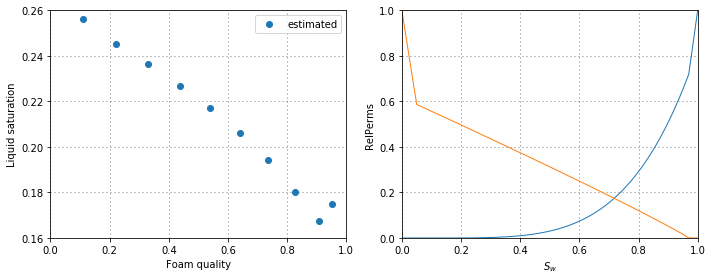

In [7]:
sw_plt = np.linspace(0.0,1.0, 100)
sw_plt = sw_plt.reshape([len(sw_plt),1])

data['sw_exp'] = (1-swc-sgr)*(data['mu_water']*(1-data['fg'])/(krw0*data['mu_tot']))**(1/nw)+swc
sw_exp = data['sw_exp'].values.reshape([len(data['sw_exp'] ),1])

krg_plt = krg(sw_plt)
krw_plt = krw(sw_plt)

plt.figure(1, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(data['fg'], sw_exp, "o")
plt.xlabel("Foam quality")
plt.ylabel("Liquid saturation")
plt.legend(["estimated"])
plt.grid()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(sw_plt, krw_plt, sw_plt, krg_plt)
plt.xlabel(r"$S_w$")
plt.ylabel("RelPerms")
plt.grid()
plt.tight_layout()

In [8]:
transition = pd.DataFrame(np.nan,np.arange(1),columns=['trans_ind','fg_trans','mu_trans'])

# transition fron low- to high-quality
transition['trans_ind'] = data['mu_tot'].idxmax(axis=0, skipna=True)
transition['fg_trans']  = data['fg'].iloc[transition['trans_ind'].iloc[0]]
transition['mu_trans']  = data['mu_tot'].iloc[transition['trans_ind'].iloc[0]]


Fitting parameters from Boeije-Rossen method:
           fmmob     epdry     fmdry     fmcap     epcap
0  462505.086837  100000.0  0.185311  0.000189  2.261176


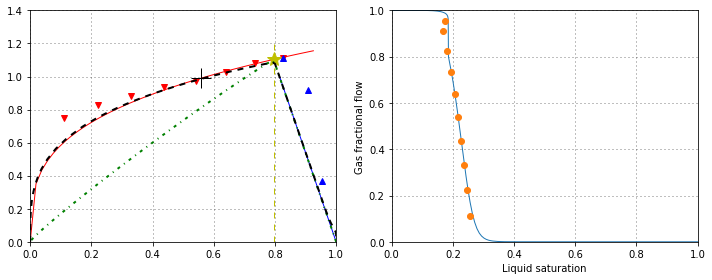

In [9]:
# Boeije-Rossen fitting method
# fit a line to the high quality data | y=a+b*x

# high_qual_append = [1, 0]  
# high_quality.loc[len(high_quality)] = high_qual_append  

reg_high = stats.linregress(high_quality['fg_high'], high_quality['muf_high'])                                    # linear regression for high quality region + [1 0]

a_high = pd.DataFrame(np.nan,np.arange(1),columns=['slope','intercept'])
a_high['slope'] = reg_high[0]
a_high['intercept'] = -reg_high[0] #reg_high[1]

# a = reg_high[0]
# b = reg_high[1]
# a_high = [-a, a]


log_fg_low = np.log(low_quality['fg_low']).values.reshape([len(low_quality), 1])
log_muf_low = np.log(low_quality['muf_low']).values.reshape([len(low_quality), 1])

w2  = np.ndarray(shape = (len(low_quality),), 
                 buffer = np.ones(len(low_quality)))                                                    
w2[-3:] = 5000  # weight factor

linreg = linear_model.LinearRegression()
reg_low = linreg.fit(log_fg_low, log_muf_low, sample_weight=w2)
a_low = pd.DataFrame(np.nan,np.arange(1),columns=['slope','intercept'])
a_low['slope'] = reg_low.coef_
a_low['intercept'] = reg_low.intercept_

low_range = pd.DataFrame(columns=['fg_low_range','muf_low_range'])
high_range = pd.DataFrame(columns=['fg_high_range','muf_high_range'])

low_range.loc[:,'fg_low_range'] = np.linspace(0.0, np.max(low_quality['fg_low'])+0.1, 50) 
low_range.loc[:,'muf_low_range'] = np.exp(a_low['intercept'].iloc[0]) \
                                   *low_range.loc[:,'fg_low_range']**a_low['slope'].iloc[0]

high_range.loc[:,'fg_high_range'] = np.linspace(np.max(low_quality['fg_low'])-0.01, 1.0, 10) 
high_range.loc[:,'muf_high_range']= a_high['intercept'].iloc[0]+a_high['slope'].iloc[0] \
                                    *high_range.loc[:,'fg_high_range']

plt.figure(2, figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(low_quality['fg_low'], low_quality['muf_low'], "vr", 
         low_range['fg_low_range'], low_range['muf_low_range'], "r-")
plt.plot(high_quality['fg_high'], high_quality['muf_high'], "b^",
         high_range['fg_high_range'], high_range['muf_high_range'], "b-")
plt.xlim([0, 1])
plt.grid()
plt.tight_layout()

def fun1(x):
    return np.exp(a_low['intercept'].iloc[0])*x**a_low['slope'].iloc[0] \
    - (a_high['slope'].iloc[0]*x + -a_high['slope'].iloc[0])

sol = optimize.root(fun1, np.max(low_quality['fg_low']))
fg_trans = sol.x

muf_trans = -a_high['slope'].iloc[0]+a_high['slope'].iloc[0]*fg_trans
plt.figure(2, figsize=[10,4])
plt.plot(fg_trans, muf_trans, "*y", markersize=15)
plt.plot([fg_trans, fg_trans], [0.0, 1.1*muf_trans], "--y", linewidth=1)

# find the transition saturation (or fmdry)
sw_trans = (1-swc-sgr)*(data['mu_water'].iloc[transition['trans_ind'].iloc[0]]* \
                        (1-fg_trans)/(krw0*muf_trans))**(1/nw)+swc
fmdry_br = sw_trans[0]

# find fmmob
FM_trans = np.array([1.])
muw1 = data['mu_water'].iloc[transition['trans_ind'].iloc[0]]
mug1 = data['mu_gas'].iloc[transition['trans_ind'].iloc[0]]
FM_trans[0] = mug1/muw1 * fg_trans/(1-fg_trans)*(krw(sw_trans)/krg(sw_trans))
fmmob_br = 1.0/FM_trans[0]-1.0

# find epdry
epdry_br= 100000.0
x_br = np.ndarray(shape=(3,1), 
                  buffer = np.array([fmmob_br,epdry_br,fmdry_br]),
                  dtype = float)

sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 100),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 100))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 100))

fg_opt = fg_mod_f2(sw_val, x_br)
muf_opt = muf_mod_f2(sw_val, x_br)
plt.plot(fg_opt, muf_opt, "-.g", linewidth=2)

# calculate the epcap
fg_plus = 0.7 * fg_trans

muf_plus = np.exp(a_low['intercept'].iloc[0])*fg_plus**a_low['slope'].iloc[0]
plt.plot(fg_plus, muf_plus, "k+", markersize=20)

sw_plus  = (1-swc-sgr)*(muw1*(1-fg_plus)/(krw0*muf_plus))**(1/nw)+swc

epcap_br = np.log((krg(sw_trans)[0]*muf_plus[0]-fg_plus[0]*mug1)/
           (fmmob_br*mug1*fg_plus[0]))/np.log(muf_trans[0]/muf_plus)
epcap_br = epcap_br[0]
# calculate fmcap
transition['trans_ind'] = data['mu_tot'].idxmax(axis=0, skipna=True)
ind_muf_min = data['mu_tot'].idxmin(axis=0, skipna=True)
fmcap_br = data['mu_tot'].iloc[ind_muf_min]*data['ut'].iloc[ind_muf_min]/sigma_wg
# correct for fmmob
fmmob_br_new = fmmob_br*(muf_trans[0]/data['mu_tot'].iloc[ind_muf_min])**epcap_br

x_br2 = np.ndarray(shape=(5,1), 
                  buffer = np.array([fmmob_br_new,epdry_br,fmdry_br,fmcap_br,epcap_br]),
                  dtype = float)

n1 = np.size(sw_val)
muf_br = np.zeros((n1, 1))
u_min = np.min(data['ut'])
u_max = np.max(data['ut'])
u_ave = np.mean(data['ut'])


F2 = x_br2[0:3,0] #[x_br2[0, 0], x_br2[1, 0], x_br2[2, 0]]
F5 = [x_br2[3, 0], x_br2[4, 0]]

r = 0
for s in sw_val:
    sw_p = np.ndarray(shape = (1,),dtype=float)
    sw_p[0] = s
    def fmu(x):
        return float(x - muf_mod_f2f5(sw_p, F2, F5, x, u_ave))

    sol = optimize.root(fmu, 0.9)
    muf_br[r, 0] = sol.x
    r = r +1

fg_br = fg_mod_f2f5(sw_val, F2, F5, muf_br, u_ave)
muf_mod_br = muf_mod_f2f5(sw_val, F2, F5, muf_br, u_ave)

plt.plot(fg_br, muf_mod_br, "k--", linewidth=2)
plt.subplot(1,2,2)
plt.plot(sw_val, fg_br, sw_exp, data['fg'], "o")
plt.xlabel("Liquid saturation")
plt.ylabel("Gas fractional flow")
plt.grid()
plt.tight_layout()

fit_br = np.array([fmmob_br_new, epdry_br, fmdry_br, fmcap_br, epcap_br])

param_br = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_br['fmmob'] = fmmob_br_new
param_br['epdry'] = epdry_br
param_br['fmdry'] = fmdry_br
param_br['fmcap'] = fmcap_br
param_br['epcap'] = epcap_br


print("Fitting parameters from Boeije-Rossen method:")
print(param_br)
# ##############################################################################


In [18]:
# 0 = np.array([2.3e5,10000,0.17,1e-4 ,2.5])
# # x0 = np.array([1e4, 1e4, 0.15, 0.001, 1.5])
# # bound = ([10,10,swc,1e-4,0] , [1e8,1e5,sw_trans+0.05,1e-2,4])

x0 = np.ndarray(shape=(5,) , 
               buffer = np.array([2.2e5,10000,0.15,1e-4,2.1]),
               dtype = float) 

lb = np.ndarray(shape=(5,) , 
               buffer = np.array([1,1,0.19,1e-4,2]),
               dtype = float) 
ub = np.ndarray(shape=(5,) , 
               buffer = np.array([1e9,1e5,0.3,1e-3,3]),
               dtype = float) 
# bound =[lb,ub]
bound = ([10,10000,swc,1e-4,2] , [1e8,1e5,sw_trans,1e-2,4])
w = np.ndarray(shape=(len(sw_exp),) , 
               buffer = np.ones(len(sw_exp,)),
               dtype = float)
w[transition['trans_ind'].iloc[0]] = 1e5
w

array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+05,   1.00000000e+00,
         1.00000000e+00])

In [19]:
# Least square 
labdaw = krw(sw_exp)/data['mu_water'].values.reshape(len(data['mu_water']),1)                                                 # water mobility
labdag = krg(sw_exp)/data['mu_gas'].values.reshape(len(data['mu_gas']),1)           

muf_exp = data['mu_tot'].values.reshape([len(data['mu_tot']),1])
u_exp = data['ut'].values.reshape([len(data['ut']),1])

# def misfit(x):
#     return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(x[1]*(sw_exp-x[2]))/np.pi)*
#                                            (x[3]/(u_exp*muf_exp/sigma_wg))**x[4])))/muf_exp)**2)

def misfit(x):
    return sum(w*(muf_mod_f2f5(sw_exp, x[0:3], x[3:5], muf_exp, u_exp) - muf_exp)**2)

es = optimize.least_squares(misfit, x0, bounds=bound)

foam_param_ls = np.ndarray(shape=(5,1),dtype=float)
foam_param_ls = es.x.reshape([5,1])
param_ls = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_ls['fmmob'] = foam_param_ls[0, 0]
param_ls['epdry'] = foam_param_ls[1, 0]
param_ls['fmdry'] = foam_param_ls[2, 0]
param_ls['fmcap'] = foam_param_ls[3, 0]
param_ls['epcap'] = foam_param_ls[4, 0]

print(param_ls)


           fmmob         epdry     fmdry     fmcap     epcap
0  568977.341127  10000.000001  0.182773  0.000139  2.005654


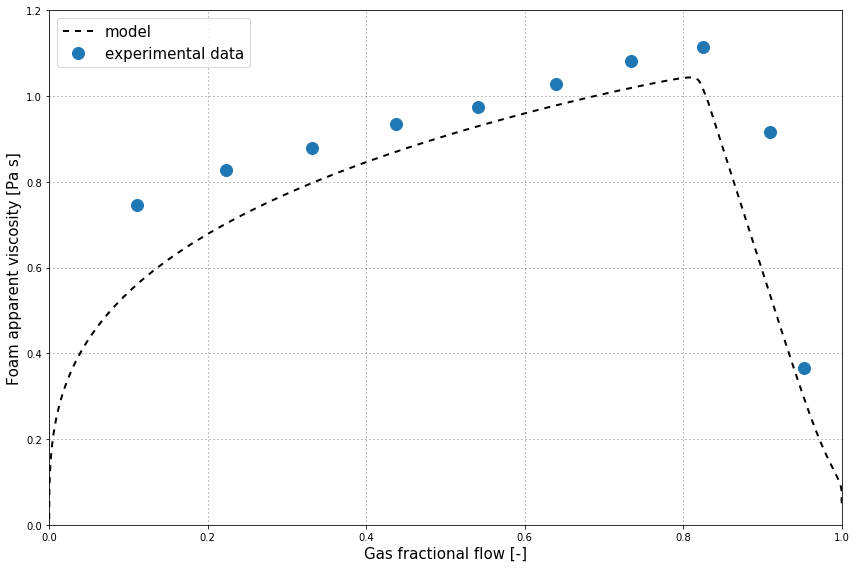

In [20]:
# Fit visualization
sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 300),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 300))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 300))

n1 = np.size(sw_val)
muf_ls = np.ndarray(shape = (n1,1), buffer = np.zeros((n1, 1)),
                     dtype= float)
u_min = np.min(data['ut'])
u_max = np.max(data['ut'])
u_ave = float(np.mean(data['ut']))

F22 = [foam_param_ls[0, 0], foam_param_ls[1, 0], foam_param_ls[2, 0]]
F52 = [foam_param_ls[3, 0], foam_param_ls[4, 0]]

r = 0
for s in sw_val:
    ss = np.ndarray(shape = (1,),dtype=float)
    ss[0] = s
    def fmu2(x):
        return float(x - muf_mod_f2f5(ss, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_ls[r, 0] = sol.x
    r = r + 1

fg_ls = fg_mod_f2f5(sw_val, F22, F52, muf_ls, u_ave)
muf_mod_ls = muf_mod_f2f5(sw_val, F22, F52, muf_ls, u_ave)

plt.figure(figsize=[12,8])
plt.plot(fg_ls, muf_mod_ls, "k--", linewidth=2,label='model')
plt.plot(data['fg'], data['mu_tot'], "o",markersize =12,label='experimental data')
plt.ylabel("Foam apparent viscosity [Pa s]",fontsize=15)
plt.xlabel("Gas fractional flow [-]",fontsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=15)

plt.show()



In [27]:
# labdaw = krw(sw_exp)/muw                                                  # water mobility
# labdag = krg(sw_exp)/mug

# x0 = np.array([100000, 100000, 0.1696, 0.000175, 2.2222])
x0 = np.array([1000, 0.15, 0.0001, 2.5])

x0 = np.ndarray(shape=(5,) , 
               buffer = np.array([2.2e5,10000,0.15,1e-4,2.1]),
               dtype = float) 
bound_opt = ((10, 1e8), (swc, sw_trans), (1e-4, 1e-2), (2, 4))

w = np.ones((np.size(sw_exp), 1))
# w[int(ind_mu_max)-4:int(ind_mu_max)] = 1e0
# w[int(ind_mu_max)+1:int(ind_mu_max)+2] = 5e5


muf_exp = data['mu_tot'].values.reshape([len(data['mu_tot']),1])
u_exp = data['ut'].values.reshape([len(data['ut']),1])

# def misfit(x):
#     return sum(w*(1.0-(1.0/(labdaw+labdag/(1.0+x[0]*(0.5+np.arctan(1e5*(sw_exp-x[1]))/np.pi)*
#                                            (x[2]/(u_exp*muf_exp/sigma_wg))**x[3])))/muf_exp)**2)
def misfit(x):
    return sum(w*(muf_mod_f2f5(sw_exp, x[0:3], x[3:5], muf_exp, u_exp) - muf_exp)**2)

es = optimize.minimize(misfit, x0, method='CG', bounds=bound_opt, 
                       options={'disp': True, 'eps': 1e-4})


foam_param_opt = np.ndarray(shape=(5,1),dtype=float)
foam_param_opt = es.x.reshape([5,1])
param_opt = pd.DataFrame(np.nan,np.arange(1),columns = ['fmmob','epdry','fmdry','fmcap','epcap'])
param_opt['fmmob'] = foam_param_opt[0, 0]
param_opt['epdry'] = foam_param_opt[1, 0]
param_opt['fmdry'] = foam_param_opt[2, 0]
param_opt['fmcap'] = foam_param_opt[3, 0]
param_opt['epcap'] = foam_param_opt[4, 0]

print(param_opt)




Optimization terminated successfully.
         Current function value: nan
         Iterations: 1
         Function evaluations: 343
         Gradient evaluations: 49
      fmmob    epdry     fmdry      fmcap     epcap
0  220000.0  10000.0  0.151307 -1034.2399  2.075546


/Users/siavash/Software/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in power


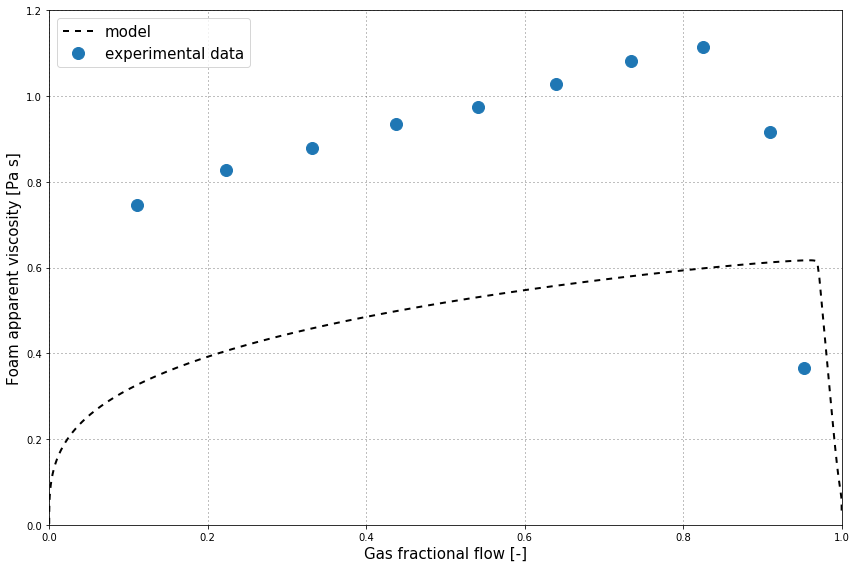

In [24]:
sw_val1 = np.append(np.linspace(0.0, np.min(sw_exp), 300),
                     np.linspace(np.min(sw_exp)+np.finfo(float).eps, np.max(sw_exp), 300))
sw_val = np.append(sw_val1, np.linspace(np.max(sw_exp) + np.finfo(float).eps, 1.0, 300))

n1 = np.size(sw_val)
muf_opt = np.ndarray(shape = (n1,1), buffer = np.zeros((n1, 1)),
                     dtype= float)
u_min = np.min(data['ut'])
u_max = np.max(data['ut'])
u_ave = float(np.mean(data['ut']))

F22 = [foam_param_opt[0, 0], foam_param_opt[1, 0], foam_param_opt[2, 0]]
F52 = [foam_param_opt[3, 0], foam_param_opt[4, 0]]

r = 0
for s in sw_val:
    ss = np.ndarray(shape = (1,),dtype=float)
    ss[0] = s
    def fmu2(x):
        return float(x - muf_mod_f2f5(ss, F22, F52, x, u_ave))

    sol = optimize.root(fmu2, 0.9)
    muf_opt[r, 0] = sol.x
    r = r + 1


fg_opt = fg_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)
muf_mod_opt = muf_mod_f2f5(sw_val, F22, F52, muf_opt, u_ave)

plt.figure(figsize=[12,8])
plt.plot(fg_opt, muf_mod_opt, "k--", linewidth=2,label='model')
plt.plot(data['fg'], data['mu_tot'], "o",markersize =12,label='experimental data')
plt.ylabel("Foam apparent viscosity [Pa s]",fontsize=15)
plt.xlabel("Gas fractional flow [-]",fontsize=15)
plt.grid()
plt.tight_layout()
plt.legend(fontsize=15)

plt.show()

